In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import networkx as nx

%matplotlib inline

In [ ]:
relation_reader = pd.read_csv('relations.csv', iterator=True,delimiter='\t', names=['day', 'time_ms', 'src', 'dst', 'relation'], chunksize=1000)

In [3]:
start = timer()
relation_5 = pd.concat([chunk[chunk['relation']==5] for chunk in relation_reader])
end = timer()
print(end - start) # Time in seconds

2663.9105096069998


In [18]:
len(relation_5)

150877446

In [89]:
def diffusion(df, num_of_nodes):
    node_list = []
    #relation_list = []
    neighbors = [df.iloc[0]['src']]
    node_list.extend(neighbors)
    hop = 0
    while len(node_list) < num_of_nodes:
        # gather src and dst relations
        # relation_list.append(df[(df['src'].isin(neighbors)) & (df['dst'].isin(neighbors))])
        # gather src and dst neighbor node list
        neighbors = df[df['src'].isin(neighbors)]['dst'].tolist() + df[df['dst'].isin(neighbors)]['src'].tolist()
        # add to the network
        node_list.extend(neighbors)
        # remove the duplicates
        node_list = list(set(node_list))
        hop = hop + 1
        print('At hop-{}, number of users acquired: {}'.format(hop, len(set(neighbors))))
    print('Filtering the connections...')
    correct_rel = df[(df['src'].isin(node_list)) & (df['dst'].isin(node_list))]
    return node_list, correct_rel

In [88]:
start = timer()
node_list, correct_rel = diffusion(relation_5, 38)
end = timer()
print(end - start) # Time in seconds

At hop-1, number of users acquired: 36
At hop-2, number of users acquired: 62137
118.83631043499918


In [94]:
G=nx.from_pandas_edgelist(correct_rel, source='src', target='dst')

In [95]:
print('Number of nodes: {}, Number of edges: {}'. format(G.number_of_nodes(), G.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(G.number_of_selfloops(), nx.number_connected_components(G)))

Number of nodes: 62173, Number of edges: 66919
Number of self-loops: 0, Number of connected components: 1


### Get the corresponding user list

In [2]:
correct_rel.to_csv('filtered_relations.csv', index=False)
relations = pd.read_csv('filtered_relations.csv')
relations.head()

,day,time_ms,src,dst,relation
0,0,7857852,1,3993630,5
1,0,7860977,1,3181660,5
2,0,7862420,1,1582548,5
3,0,7866986,1,5208994,5
4,2,21455967,1,2330216,5


In [3]:
all_users = pd.read_csv('usersdata.csv',delimiter='\t', names=['User Id','Gender', 'Time', 'Age Range','Spammer Label'])

In [4]:
user_list = set(relations.src.tolist() + relations.dst.tolist())

In [5]:
len(user_list)

62173

In [6]:
users = all_users[all_users['User Id'].isin(user_list)]

In [7]:
len(users)

62173

In [8]:
users.head()

,User Id,Gender,Time,Age Range,Spammer Label
0,1,M,0.9000,30,0
189,190,M,0.2000,50,0
269,270,M,0.2625,30,0
318,319,M,0.0000,30,0
406,407,M,0.0500,50,0


[0, 50, 0, 6000]

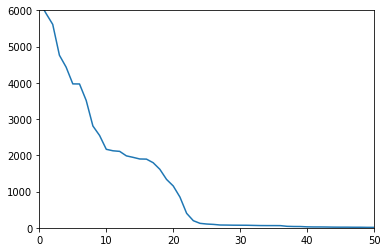

In [15]:
degree_sequence=sorted(nx.degree(G).values(),reverse=True)
plt.plot(np.array(degree_sequence));
plt.axis([0, 50, 0, 6000])

In [5]:
users['Spammer Label'].value_counts()

0    59725
1     2448
Name: Spammer Label, dtype: int64